In [1]:
using PyPlot, PyCall
using JuMP, Ipopt
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

In [2]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [3]:
model = ClimateModel();
@time optimize_controls!(model, obj_option = "net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 38.417239 seconds (113.83 M allocations: 6.454 GiB, 6.07% gc time)


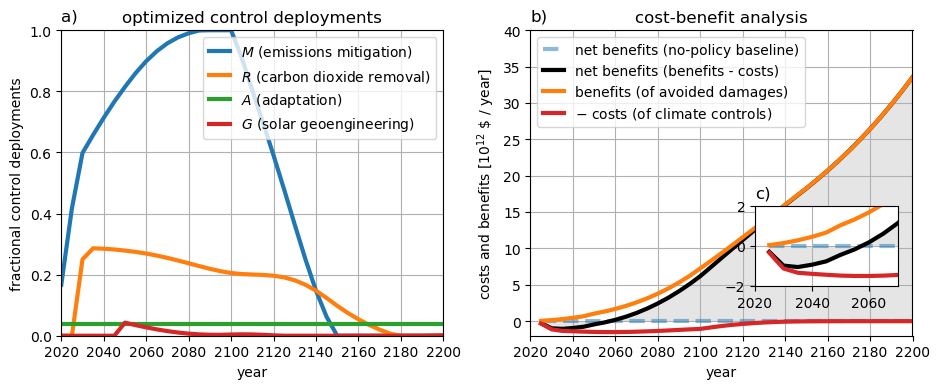

In [4]:
fig = figure(figsize=(9.5,4.0))

fig.add_subplot(1,2,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
add_label("a)")

ax = fig.add_subplot(1,2,2)
plot_benefits(model)
legend(handlelength=1.5, loc="upper left")
add_label("b)")
ylim([-2., 40.])

iax = fig.add_axes([0.8, 0.27, 0.15, 0.2])
sca(iax)
plot_benefits(model)
ylabel("")
xlabel("")
ylim([-2., 2.])
xlim([2020,2070])
title("")
title("c)", loc="left")

tight_layout()
savefig("../figures/default-benefits_controls_and_benefits.png", dpi=200, bbox_inches="tight")

#### Approach 2: Avoiding damage thresholds

In [5]:
model = ClimateModel();
@time optimize_controls!(model);

  0.751392 seconds (844.27 k allocations: 39.819 MiB, 5.46% gc time)


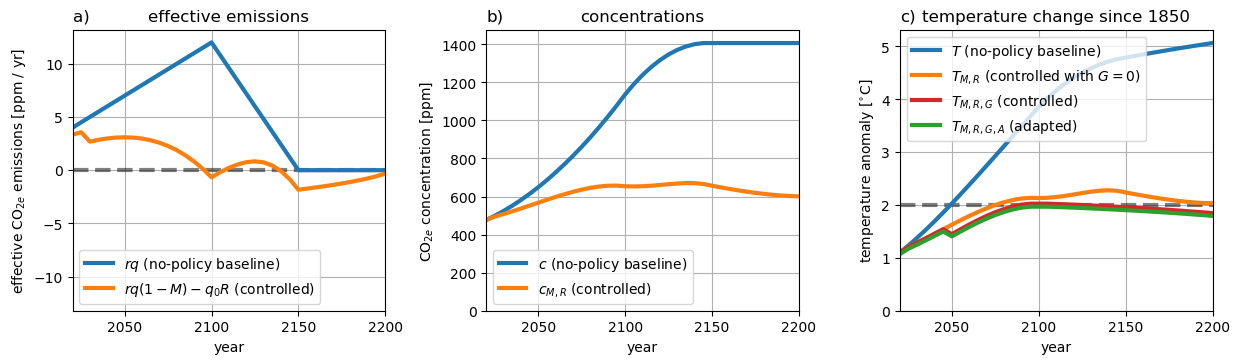

In [6]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
add_label("a)")
subplot(1,3,2)
plot_concentrations(model)
legend()
add_label("b)")
subplot(1,3,3)
plot_temperatures(model)
legend()
add_label("c)")
tight_layout()
savefig("../figures/default-temp_carbon_and_temperatures.png", dpi=200, bbox_inches="tight")

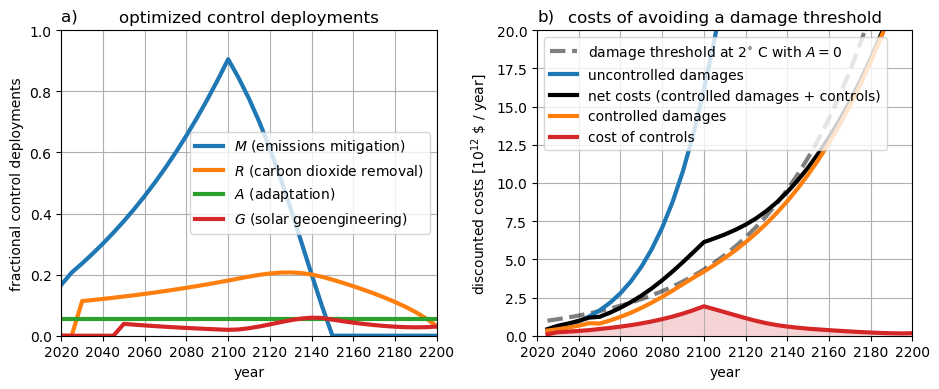

In [7]:
figure(figsize=(9.5,4.0))

subplot(1,2,1)
plot_controls(model)
legend()
add_label("a)")
subplot(1,2,2)
plot_damages(model)
legend(loc="upper left")
add_label("b)")
ylim([0, 20])
tight_layout()
savefig("../figures/default-temp_controls_and_damages.png", dpi=200, bbox_inches="tight")